In [1]:
import matplotlib as mpl
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import networkx as nx
import netwulf as nw
from itertools import combinations
from collections import defaultdict
import random
from scipy import stats
from networkx.algorithms import community

seed = 1337
random.seed(seed)
np.random.seed(seed)

In [2]:
song_data = pd.read_pickle('songData.df')
print(f'Number of songs: {len(song_data)}')

Number of songs: 25419


In [3]:
song_data.head()

,released,artists,lyrics,genres,title
0,1957,[marty robbins],\nOut in the West Texas town of El Paso\nI fel...,[country],El Paso
1,1960-01-04,[frankie avalon],I'll never let you go\nWhy? Because I love you...,[pop],Why
3,1959,[johnny preston],"On the bank of the river\nStood Running Bear, ...",[pop],Running Bear
4,1960-01-04,[freddy cannon],"Well, way down yonder in New Orleans\nIn the l...",[pop],Way Down Yonder in New Orleans
5,1960-01-04,[guy mitchell],"\nHeartaches by the number, troubles by the sc...","[country, cover]",Heartaches by the Number


## Create the network (graph)

In [4]:
all_artists = set()
artist_genres = dict()
artist_genres_count = defaultdict(lambda: defaultdict(lambda: 0))
for artists, genres in zip(song_data.artists, song_data.genres):
    for artist in artists:
        all_artists = all_artists.union(set([artist]))
        for genre in genres:
            artist_genres_count[artist][genre] += 1
        if artist in artist_genres.keys():
            artist_genres[artist] = artist_genres[artist].union(set(genres))
        else:
            artist_genres[artist] = set(genres)
        

all_artists = list(all_artists)
print(f'Number of unique artists: {len(all_artists)}')

Number of unique artists: 7855


In [5]:
genre_list = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul', 
              'singer-songwriter', 'pop-rock', 'trap', 'ballad', 
             'soul pop', 'eighties', 'uk', 'seventies', 'soundtrack',
             'hip-hop', 'funk']

In [6]:
artist_count = defaultdict(lambda: 0)
artist_colab_count = defaultdict(lambda: defaultdict(lambda: 0))

for artists in song_data.artists:
    for artist in artists:
        artist_count[artist] += 1
        for colab in artists:
            if colab != artist:
                artist_colab_count[artist][colab] += 1

In [7]:
G = nx.Graph()
for artist in all_artists:
    # genre_exists = False
    # for genre in genre_list:
    #     if genre in artist_genres_count[artist]:
    #         genre_exists = True
    #         break
    # if not genre_exists:
    #     max_keys = ['other']
    # else:
    most_occurences = 0
    max_key = 'other'
    for genre in genre_list:
        if artist_genres_count[artist][genre] > most_occurences:
            most_occurences = artist_genres_count[artist][genre]
            max_key = genre


    G.add_node(artist, genre=max_key, weight=artist_count[artist], all_genres=artist_genres[artist])
    
G.number_of_nodes()

7855

In [8]:
nx.get_node_attributes(G, "genre")

{'harakiri, jr.': 'rap',
 'king combs': 'rap',
 'juliet simms': 'pop',
 'morgan wallen': 'country',
 'blue öyster cult': 'rock',
 'buzz clifford': 'pop',
 'fotomaker': 'pop',
 'the nightcrawlers (rock)': 'pop',
 'larry groce': 'pop',
 'the cleftones': 'pop',
 'the cataracs': 'rap',
 'arizona zervas': 'pop',
 'dann rogers': 'pop',
 'the vandals': 'rock',
 'stevie b': 'pop',
 'taco': 'pop',
 'the mighty clouds of joy': 'pop',
 'the dominoes': 'pop',
 'hoyt axton': 'pop',
 'jackie ross': 'pop',
 'curtie': 'pop',
 'the girl and the dreamcatcher': 'pop',
 'eddie': 'pop',
 'tony! toni! toné!': 'r&b',
 'harry connick, jr.': 'pop',
 'havana brown': 'pop',
 'janet jackson': 'r&b',
 'anastacia': 'pop',
 'the matadors': 'r&b',
 'kayak': 'pop',
 'dire straits': 'rock',
 'addrisi brothers': 'pop',
 'the lemonheads': 'rock',
 'jojo, kevon edmonds': 'r&b',
 'bryan ferry': 'pop',
 'tha eastsidaz': 'rap',
 'christie': 'pop',
 'roger hodgson': 'pop',
 'david porter': 'r&b',
 'swae lee': 'rap',
 'esther 

In [9]:
linked_artists = set()
for artists in song_data.artists:
    if len(artists) > 1:
        for comb in combinations(artists, 2):
            if not comb[0] == comb[1]:
                linked_artists = linked_artists.union({tuple([comb[0], comb[1], artist_colab_count[comb[0]][comb[1]]])})

linked_artists = list(linked_artists)
print(f'Number of edges: {len(linked_artists)}')

Number of edges: 7098


In [10]:
linked_artists

[('buddy emmons', 'judy collins', 1),
 ('h.e.r.', 'niall horan', 1),
 ('gucci mane', 'travis scott', 1),
 ('houston', 'chingy', 1),
 ('jason derulo', 'luke bryan', 1),
 ('oh no', 'fashawn', 1),
 ('bravo all stars', 'blümchen', 1),
 ('lil wayne', 'wiz khalifa', 2),
 ('smokepurpp', 'bas', 1),
 ('leann rimes', 'natasha bedingfield', 1),
 ('juelz santana', 'ron browz', 1),
 ('the knocks', 'sofi tukker', 1),
 ('bing crosby', 'the andrews sisters', 2),
 ('howard hewett', 'jeffrey daniel', 1),
 ('alicia keys', 'dr. dre', 1),
 ('grandmaster flash', 'the furious five', 1),
 ('gabe saporta', 'mc lars', 1),
 ('keith sweat', 'silk', 1),
 ('otis redding', 'jay-z', 1),
 ('matthew ward', 'donna summer', 1),
 ('breland', 'hardy', 1),
 ("colby o'donis", 'akon', 2),
 ('rich the kid', 'blueface', 1),
 ('buddy', 'smokepurpp', 1),
 ('tyrese', 'chingy', 1),
 ('mack maine', 'birdman', 2),
 ('jeremih', 'nicki minaj', 1),
 ('ray charles', 'quincy jones', 1),
 ('gary lewis', 'the playboys', 13),
 ('outkast', 'w

In [11]:
G.add_weighted_edges_from(linked_artists)
G.number_of_edges()

6799

In [ ]:
networkRand, config = nw.visualize(G, plot_in_cell_below=False)

In [13]:
for node, data in G.nodes(data=True):
    print(node)
    print(data['all_genres'])

harakiri, jr.
{'rap'}
king combs
{'new york', 'east coast', 'r&b', 'rap'}
juliet simms
{'pop'}
morgan wallen
{'alternative', 'rock', 'alternative r&b', 'alternative pop', 'pop country', 'trap', 'country', 'adult contemporary', 'rap', 'r&b', 'acoustic', 'piano', 'chill', 'easy listening', 'chicago rap', 'alternative country', 'americana', 'bluegrass', 'honky tonk', 'hip-hop', 'chicago drill', 'ballad', 'pop', 'outlaw country', 'cover', 'country rap', 'pop rap', 'drill', 'soft rock', 'singer-songwriter', 'blues'}
blue öyster cult
{'rock', 'pop-rock', 'alternative rock', 'album-oriented rock (aor)', 'ballad', 'pop', 'acoustic', 'hard rock', 'psychedelic rock'}
buzz clifford
{'pop'}
fotomaker
{'pop'}
the nightcrawlers (rock)
{'pop', 'rock'}
larry groce
{'pop'}
the cleftones
{'pop'}
the cataracs
{'electro house', 'pop', 'electro-hop', 'pop rap', 'electro-pop', 'dance-pop', 'rap'}
arizona zervas
{'pop', 'pop rap', 'rap'}
dann rogers
{'pop'}
the vandals
{'rock'}
stevie b
{'pop', 'new jack swi

In [14]:
def get_network_by_genre(G, genre):
    genre_nodes = [node for node, data in G.nodes(data=True) if genre in data['all_genres']]
    return G.subgraph(genre_nodes)

In [58]:
new_G = nw.get_filtered_network(G, node_group_key='genre')
# G_partitioning = get_partitioning(new_G)
# karate_modularity = modularity(G, G_partitioning)

In [21]:
networkRand, config = nw.visualize(nw.get_filtered_network(get_network_by_genre(G, 'hip-hop'), node_group_key='genre'), plot_in_cell_below=False)

In [59]:
networkRand, config = nw.visualize(new_G, plot_in_cell_below=False)

## Properties of the network

In [105]:
print(f'Number of Nodes: {G.number_of_nodes()}')
print(f'Number of Links: {G.number_of_edges()}')
print(f'Density: {nx.density(G):.5f}')

print(f'Avg. clustering: {nx.average_clustering(G):.2f}')
degrees = list(dict(G.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 8407
Number of Links: 9166
Density: 0.00026
Avg. clustering: 0.18
Average degrees: 2.18
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 112


In [110]:
sorted_degrees = {k: v for k, v in sorted(dict(G.degree()).items(), key=lambda item: item[1], reverse=True)}

In [111]:
sorted_degrees

{'lil wayne': 112,
 'kanye west': 99,
 'drake': 93,
 'nicki minaj': 88,
 'young thug': 84,
 'chris brown': 71,
 'yg': 62,
 'travis scott': 62,
 'jay-z': 61,
 'future': 58,
 'eminem': 56,
 'ludacris': 55,
 'fat joe': 52,
 'snoop dogg': 51,
 'dj khaled': 50,
 'tyga': 49,
 'rick ross': 49,
 'killer mike': 49,
 'big sean': 47,
 'justin bieber': 47,
 'nipsey hussle': 46,
 'beyoncé': 46,
 'prodigy of mobb deep': 46,
 'lil baby': 46,
 't.i.': 46,
 't-pain': 44,
 '2 chainz': 43,
 'wiz khalifa': 42,
 'raekwon': 42,
 'pusha t': 41,
 'problem': 41,
 'meek mill': 40,
 'diddy': 40,
 'ty dolla $ign': 39,
 'action bronson': 39,
 'pitbull': 38,
 'rockie fresh': 38,
 'rihanna': 38,
 'flatbush zombies': 38,
 'missy elliott': 38,
 'mary j. blige': 38,
 'meyhem lauren': 37,
 'mariah carey': 37,
 'alexander spit': 36,
 'zebra katz': 36,
 'cuz lightyear': 36,
 'bobby creekwater': 36,
 'remy banks': 36,
 'renegade el rey': 36,
 'lil durk': 36,
 'mike g': 36,
 'two-9': 36,
 'nigel nasty': 36,
 'da$h': 36,
 'k

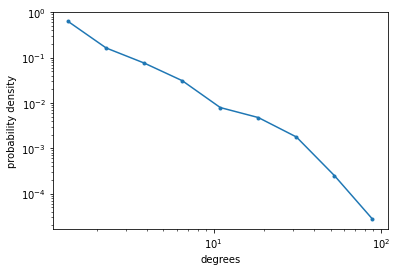

In [125]:
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [137]:
con_com = nx.algorithms.connected_components(G)
largest_cc = max(nx.connected_components(G), key=len)
gia_com = G.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.99602
